<a href="https://colab.research.google.com/github/rylan-berry/DeepLearningIndependentStudy/blob/main/OptimizationLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Making Regularization Algorithms from Scratch

##Sub Model Structuring

###Auto Gradient

In [198]:
class Values:
  def __init__(self, vals, grads = True):
    self.vals = np.array(vals)
    self._backward = lambda: None
    self.grad = np.zeros_like(vals)
    self.grad_flag = grads

  #Gemini code that handles wierd broadcasting errors
  @staticmethod
  def _broadcast_grad(grad_from_output, original_shape):
    """
    Adjusts the gradient by summing over broadcasted dimensions to match the original shape.
    Assumes `grad_from_output` has the shape of the broadcasted result.
    `original_shape` is the shape of the tensor *before* broadcasting.
    """

    if grad_from_output.shape == original_shape:
        return grad_from_output

    # If original was a scalar, sum all dimensions of the gradient
    if original_shape == (): # scalar
        return np.sum(grad_from_output)

    # Identify axes where original_shape has size 1 and grad_from_output has size > 1
    axes_to_sum = []

    # Handle cases where original_shape might have fewer dimensions than grad_from_output
    # e.g., (D,) broadcast to (N, D). original_shape is padded implicitly with 1s on the left.
    diff_ndim = grad_from_output.ndim - len(original_shape)
    padded_original_shape = (1,) * diff_ndim + original_shape

    for i in range(grad_from_output.ndim):
        if padded_original_shape[i] == 1 and grad_from_output.shape[i] > 1:
            axes_to_sum.append(i)

    if axes_to_sum:
        return np.sum(grad_from_output, axis=tuple(axes_to_sum), keepdims=True)

    return grad_from_output # No broadcasting to sum over, or complex broadcasting not handled by this simple logic.

  def __repr__(self):
    return "vals: " + self.vals.__repr__() + "\ngrads: "+ self.grad.__repr__()

  def __add__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals + other.vals)
    def backward():
      if self.grad_flag:
        self_grad_to_add = Values._broadcast_grad(out.grad, self.vals.shape)
        self.grad = self.grad + self_grad_to_add
        self._backward()
      if other.grad_flag:
        other_grad_to_add = Values._broadcast_grad(out.grad, other.vals.shape)
        other.grad = other.grad + other_grad_to_add
        other._backward()

    out._backward = backward
    return out
  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __mul__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals * other.vals)
    def backward():
      if self.grad_flag:
        # Gradient for self is `other.vals * out.grad`
        grad_term_for_self = other.vals * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term_for_self, self.vals.shape)
      if other.grad_flag:
        # Gradient for other is `self.vals * out.grad`
        grad_term_for_other = self.vals * out.grad
        other.grad =other.grad + Values._broadcast_grad(grad_term_for_other, other.vals.shape)
        other._backward()
      if self.grad_flag:
        self._backward()

    out._backward = backward
    return out

  def __rmul__(self, other): #other * self
    return self * other

  def __truediv__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals / other.vals)
    def backward():
      if self.grad_flag:
        grad_term_for_self = out.grad / other.vals
        self.grad = self.grad + Values._broadcast_grad(grad_term_for_self, self.vals.shape)
      if other.grad_flag:
        grad_term_for_other = -out.grad * self.vals / (other.vals**2)
        other.grad = other.grad + Values._broadcast_grad(grad_term_for_other, other.vals.shape)
        other._backward()
      if self.grad_flag:
        self._backward()
    out._backward = backward
    return out

  def __rtruediv__(self, other):
    return Values(other) / self

  def __matmul__(self, other):
    other = other if isinstance(other, Values) else Values(other)
    out = Values(self.vals @ other.vals)
    def backward():
      if self.grad_flag:
        # out.grad @ other.vals.T matches self.vals shape, so no broadcast_grad needed here.
        self.grad = self.grad + out.grad @ other.vals.T
      if other.grad_flag:
        # self.vals.T @ out.grad matches other.vals shape, so no broadcast_grad needed here.
        other.grad = other.grad + self.vals.T @ out.grad
        other._backward()
      if self.grad_flag:
        self._backward()
    out._backward = backward
    return out

  def __rmatmul__(self, other):
    return Values(other) @ self

  def exp(self):
    out = Values(np.exp(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.vals * out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Values(self.vals**other)
    def backward():
      if self.grad_flag:
        grad_term = other * (self.vals**(other - 1)) * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def log(self):
    out = Values(np.log(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = self.vals**-1 *out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def relu(self):
    out = Values(np.maximum(0,self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.grad * (self.vals > 0)
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def abs(self):
    out = Values(np.abs(self.vals))
    def backward():
      if self.grad_flag:
        # Gradient of abs(x) is np.sign(x)
        grad_term = out.grad * np.sign(self.vals)
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def sum(self, axis=None, keepdims=False):
    out_vals = np.sum(self.vals, axis=axis, keepdims=keepdims)
    out = Values(out_vals)
    saved_axis = axis
    saved_keepdims = keepdims
    original_shape = self.vals.shape

    def backward():
        if self.grad_flag:
            grad_to_distribute = out.grad

            if saved_axis is not None and not saved_keepdims:
                new_shape = list(original_shape)
                if isinstance(saved_axis, int):
                    new_shape[saved_axis] = 1
                else:
                    for ax in saved_axis:
                        new_shape[ax] = 1
                grad_to_distribute = grad_to_distribute.reshape(new_shape)

            self.grad = self.grad + Values._broadcast_grad(grad_to_distribute, self.vals.shape)
            self._backward()
    out._backward = backward
    return out

  def softmax(self, axis=-1):
    max_val = self.vals.max(axis=axis, keepdims=True)
    exp_vals = (self - max_val).exp()
    sum_exp_vals = exp_vals.sum(axis=axis, keepdims=True)
    out = Values(exp_vals / sum_exp_vals)

    def backward():
        if self.grad_flag:
            sum_grad_times_out = (out.vals * out.grad).sum(axis=axis, keepdims=True)
            grad_term = out.vals * (out.grad - sum_grad_times_out)
            self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
            self._backward()
    out._backward = backward
    return out

  def mean(self):
    out = Values(np.mean(self.vals))
    def backward():
      if self.grad_flag:
        # For mean, out.grad is a scalar. Adding a scalar to self.grad (an array)
        # implicitly broadcasts the scalar across all elements, which is the correct behavior
        # for the gradient of a mean operation.
        self.grad = self.grad + (out.grad / self.vals.size)
        self._backward()
    out._backward = backward
    return out

  def __call__(self):
    return self

  def __getitem__(self, item):
    out = Values(self.vals[item])
    saved_item = item
    def backward():
        if self.grad_flag:
            temp_grad = np.zeros_like(self.vals)
            temp_grad[saved_item] = out.grad
            self._backward()
    out._backward = backward
    return out

  def backward(self):
    self.grad = np.ones_like(self.vals)
    self._backward()

  def __getattr__(self, name):
    if name == "_":
      return self
    if name == "T" or name == "transpose":
      out = Values(self.vals.T)
      def backward():
        if self.grad_flag:
          # out.grad is the shape of out.vals (transposed vals), so out.grad.T is the shape of self.vals.
          # No broadcast_grad needed here.
          self.grad = self.grad + out.grad.T
          self._backward()
        return
      out._backward = backward
      return out

    if hasattr(self.vals, name) and not callable(getattr(self.vals, name)):
      return getattr(self.vals, name)

    raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}' or attribute is not supported for automatic differentiation.")

###Sequence

In [199]:
class Sequence:
  def __init__(self, arr):
    self.arr = arr

  def __call__(self, x):
    x_i = x
    for item in self.arr:
      x_i = item(x_i)
    return x_i

  def params(self):
    all_params = []
    for l in self.arr:
      # Check if the item has a params method (e.g., Layer or Dense)
      if hasattr(l, 'params'):
        # layer_params should return weights and biases, which can be individual Values or lists of Values
        layer_params = l.params()
        # Ensure layer_params is iterable (e.g., a tuple of (weights, biases))
        if isinstance(layer_params, tuple) or isinstance(layer_params, list):
            for p_group in layer_params:
                # If p_group is a list (e.g., from Dense containing multiple layers),
                # extend with its elements, otherwise append the Value object itself.
                if isinstance(p_group, list):
                    all_params.extend(p_group)
                else:
                    all_params.append(p_group)

    return all_params

##Model Structuring

###Layer

In [200]:
class Layer:
  def __init__(self, input,out,activ="_",rangeW=(-1,1),rangeB=(-1,1)):
    self.weights = Values((rangeW[0]-rangeW[1])*np.random.rand(input,out)+rangeW[1])
    self.bias = Values((rangeB[0]-rangeB[1])*np.random.rand(1,out)+rangeB[1])
    self.activation = activ

  def __call__(self, x):
    y = x @ self.weights + self.bias
    if self.activation == "_": # No activation function
        return y
    else:
        # Get the method corresponding to the activation string and call it.
        # This will now correctly find methods like y.relu() or y.softmax().
        # If self.activation is not a valid method name, it will raise an AttributeError.
        activation_func = getattr(y, self.activation)
        return activation_func()

  def params(self):
    return self.weights, self.bias

###Network Block (Dense)

In [201]:
class Dense:
  def __init__(self, layNum, inL, midL, outL, activ="_",f_activ="_",rangeW=(-0.1,0.1),rangeB=(-0.1,0.1)):
    if layNum < 1:
      print("Dense can't have 0 layers or below.")
    elif layNum == 1:
      self.seq = Sequence([Layer(inL,outL,f_activ,rangeW,rangeB)])
    else:
      lays = []
      for i in range(layNum):
        if i == 0:
          lays.append(Layer(inL,midL,activ,rangeW,rangeB))
        elif i == layNum-1:
          lays.append(Layer(midL,outL,f_activ,rangeW,rangeB))
        else:
          lays.append(Layer(midL,midL,activ,rangeW,rangeB))
      self.seq = Sequence(lays)

  def __call__(self, x):
      return self.seq(x)

  def params(self):
      return self.seq.params()

###Dropout

In [202]:
class Dropout:
  def __init__(self, size, chance):
    self.size = size
    self.rate = chance
    self.inTrain = False

  def __call__(self, x):
    r = self.rate
    if r <= 0.0 or not self.inTrain:
      return x
    elif r >= 1.0:
      return Values(np.zeros_like(x.vals))

    do = Values(np.random.choice([0,1/(1-r)],size=(self.size,),p=[r, 1-r]))
    return x * do

  def updateParams(self, l_rate): #here so errors don't occur when update params is called for the whole sequence
    return



###Loss Functions

In [203]:
def cross_entropy_loss(y_true, y_pred):
  loss = -(y_true * y_pred.log()).sum(axis=1).mean()
  return loss

def mse_loss(y_true, y_pred):
  loss = ((y_true - y_pred)**2).mean()
  return loss

###Optimizers

In [204]:
class Optimizer:
  def __init__(self):
    pass

  def step(self, params, learning_rate):
    for p in params:
      p.vals = p.vals - learning_rate * p.grad
      p.grad = np.zeros_like(p.grad)

In [205]:
class Optim_SGD(Optimizer):
  def __init__(self, finitters, fin_l_rate):
    self.t = 0
    self.finitter = finitters
    self.fin_l_rate = fin_l_rate

  def step(self, params, learning_rate):
    self.t += 1
    t = self.t
    alpha = t/self.finitters
    if(alpha < 1):
      l_rate = learning_rate*(1-alpha) + alpha*self.fin_l_rate
    else:
      l_rate = self.fin_l_rate
    for p in params:
      p.vals = p.vals - l_rate * p.grad
      p.grad = np.zeros_like(p.grad)

In [206]:
class Optim_SGD_Momentum(Optimizer):
  def __init__(self,mom_beta=0.9):
    self.v = {}
    self.beta = mom_beta

  def step(self, params, learning_rate):
    v = self.v
    for p in params:
      if p not in self.v:
        v[p] = np.zeros_like(p.vals)
      v[p] = self.beta*v[p] - learning_rate*p.grad
      p.vals = p.vals + self.v[p]
      p.grad = np.zeros_like(p.grad)
    self.v = v

In [207]:
class Optim_AdaGrad(Optimizer):
  def __init__(self, gamma=0.0000001):
    self.gamma = gamma
    self.r = {}

  def step(self, params, l_rate):
    for p in params:
      if p not in self.r:
        self.r[p] = np.zeros_like(p.vals)
      self.r[p] = self.r[p] + p.grad**2
      p.vals = p.vals - l_rate * p.grad / (self.gamma + self.r[p]**0.5)
      p.grad = np.zeros_like(p.grad)

In [208]:
class Optim_RMSPropclass(Optimizer):
  def __init__(self,decay_rate, gamma=0.000001):
    self.decay_rate = decay_rate
    self.gamma = gamma
    self.r = {}
  def step(self, params, l_rate):
    dr = self.decay_rate
    for p in params:
      if p not in self.r:
        self.r[p] = np.zeros_like(p.vals)
      self.r[p] = dr*self.r[p] + (1-dr)*p.grad**2
      p.vals = p.vals - l_rate*p.grad/(self.gamma + self.r[p]**0.5)
      p.grad = np.zeros_like(p.grad)

In [209]:
class Optim_Adam(Optimizer):
  def __init__(self, beta1, beta2, gamma = 0.000001):
    self.b1 = beta1
    self.b2 = beta2
    self.gamma = gamma
    self.r = {}
    self.s = {}
    self.t = 0

  def step(self, params, l_rate):
    self.t += 1
    t = self.t
    beta1 = self.b1
    beta2 = self.b2
    for p in params:
      if p not in self.r:
        self.r[p] = np.zeros_like(p.vals)
      if p not in self.s:
        self.s[p] = np.zeros_like(p.vals)

      self.s[p] = beta1*self.s[p] + (1-beta1)*p.grad
      self.r[p] = beta2*self.r[p] + (1-beta2)*p.grad**2

      s_hat = self.s[p]/(1-beta1**t)
      r_hat = self.r[p]/(1-beta2**t)

      p.vals = p.vals - l_rate*s_hat/(self.gamma + r_hat**0.5)
      p.grad = np.zeros_like(p.grad)

###Model Class

In [210]:
class Model:
  def __init__(self, blocks, regu = "", train = True, loss_fn=None, pen_fn = None, optimizer=None):
    self.blocks = Sequence(blocks)

    # Handle optimizer instantiation
    if optimizer is None:
        self.optimizer = Optimizer()
    else:
        self.optimizer = optimizer

    self.regu = regu
    self.inTrain = train
    self.train_loss = []
    self.val_loss = []
    # Set default loss function to cross-entropy if not provided
    if loss_fn is None:
        self.loss_fn = cross_entropy_loss
    else:
        self.loss_fn = loss_fn

    if pen_fn is None:
      def emptyPenFn(loss_prev, model, _lambda):
        return loss_prev
      pen_fn = emptyPenFn
    self.pen_fn = pen_fn

  def __call__(self, x):
    x_ = x if isinstance(x, Values) else Values(x)
    return self.blocks(x_)

  def train(self, epochs, x_t, y_t, x_v, y_v, l_rate=0.01, val_run=1, _lambda=0.1, batch_size = None):
    x_trn = x_t if isinstance(x_t, Values) else Values(x_t)
    y_trn = y_t if isinstance(y_t, Values) else Values(y_t)
    x_vl = x_v if isinstance(x_v, Values) else Values(x_v)
    y_vl = y_v if isinstance(y_v, Values) else Values(y_v)
    x_trn.grad_flag = y_trn.grad_flag = x_vl.grad_flag = y_vl.grad_flag = False

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = True

    if not batch_size:
      batch_size = len(x_trn.vals)

    batches = 0
    if len(x_trn.vals) % batch_size == 0:
      batches = int(len(x_trn.vals) / batch_size)
    else:
      batches = int(len(x_trn.vals) / batch_size + 1)

    bat = np.array(range(batches))


    loss_strt = len(self.train_loss)
    if loss_strt != 0:
      loss_strt = int(self.train_loss[-1][0] + 1)
    for i in range(epochs):
      if i % val_run == 0:
          for l in self.blocks.arr:
            if isinstance(l, Dropout):
              l.inTrain = False
          y_val_hat = self.__call__(x_vl)
          val_loss_value = self.loss_fn(y_vl, y_val_hat).vals
          print(f"epoch: {i} \t loss: {val_loss_value}")
          self.val_loss.append((loss_strt+i,val_loss_value))
          for l in self.blocks.arr:
            if isinstance(l, Dropout):
              l.inTrain = True
      np.random.shuffle(bat)
      for b in range(batches):
        print(f"\rep{i}: b{b}/{batches}", end="")
        x_train_batch = x_trn[bat[b]*batch_size:(bat[b]+1)*batch_size]
        y_train_batch = y_trn[bat[b]*batch_size:(bat[b]+1)*batch_size]

        y_hat = self.__call__(x_train_batch)

        # Calculate loss using the specified loss_fn
        current_loss = self.loss_fn(y_train_batch, y_hat)

        self.train_loss.append((loss_strt+i + 1.0*b/batches,current_loss.vals))
        penalized_loss = self.pen_fn(current_loss,self,_lambda)
        penalized_loss.grad = np.ones_like(penalized_loss.vals)
        penalized_loss.backward()
        # Use the optimizer to step and clear gradients
        # Retrieve parameters within the training loop before each optimization step
        all_params = self.blocks.params()
        self.optimizer.step(all_params, l_rate)
      print("\r", end="")

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = False

###Penalty Functions

In [211]:
def l2_reg(loss_prev, model, _lambda):
  l2_pen = Values(0.0)

  for block in model.blocks.arr:
    if isinstance(block, Dense) or isinstance(block, Layer):
      weights, _ = block.params()
      for weis in weights:
        l2_pen = l2_pen + (weis**2).sum()
  return loss_prev + _lambda * l2_pen

def l1_reg(loss_prev, model, _lambda):
  l1_pen = Values(0.0)

  for block in model.blocks.arr:
    if isinstance(block, Dense) or isinstance(block, Layer):
      weights, _ = block.params()
      for weis in weights:
        l1_pen = l1_pen + (weis.abs()).sum()
  return loss_prev + _lambda * l1_pen

##XOR Lab Test
Makes sure framework works

In [212]:
x = Values(np.array([[0,0],[0,1],[1,0],[1,1]],dtype='f'))
y = Values(np.array([[0],[1],[1],[0]],dtype='f'))

In [213]:
m = Model([Dense(2,2,8,1,activ="relu",f_activ="relu")],loss_fn=mse_loss)
m.train(20, x,y,x,y, l_rate=0.1,val_run=4)
m(x)

epoch: 0 	 loss: 0.5
epoch: 4 	 loss: 0.5
epoch: 8 	 loss: 0.5
epoch: 12 	 loss: 0.5
epoch: 16 	 loss: 0.5


vals: array([[0.],
       [0.],
       [0.],
       [0.]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

In [214]:
m = Model([Dense(2,2,8,1,activ="relu",f_activ="relu")],loss_fn=mse_loss)
m.train(20, x,y,x,y, l_rate=0.1)
m(x)

epoch: 0 	 loss: 0.475683772790053
epoch: 1 	 loss: 0.3940456889013451
epoch: 2 	 loss: 0.34209318310254705
epoch: 3 	 loss: 0.3089792792502689
epoch: 4 	 loss: 0.28784928232169477
epoch: 5 	 loss: 0.2742885118510033
epoch: 6 	 loss: 0.265595381312131
epoch: 7 	 loss: 0.2600091640692112
epoch: 8 	 loss: 0.25640894077735205
epoch: 9 	 loss: 0.2540864158905912
epoch: 10 	 loss: 0.25256650038029366
epoch: 11 	 loss: 0.2515535984469034
epoch: 12 	 loss: 0.2508936536583515
epoch: 13 	 loss: 0.2504268666648116
epoch: 14 	 loss: 0.25010445894144534
epoch: 15 	 loss: 0.24986469681643786
epoch: 16 	 loss: 0.2496862395418744
epoch: 17 	 loss: 0.24954481977729873
epoch: 18 	 loss: 0.24942295336327608
epoch: 19 	 loss: 0.24931665534093078


vals: array([[0.48929601],
       [0.49445346],
       [0.49684489],
       [0.49869722]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

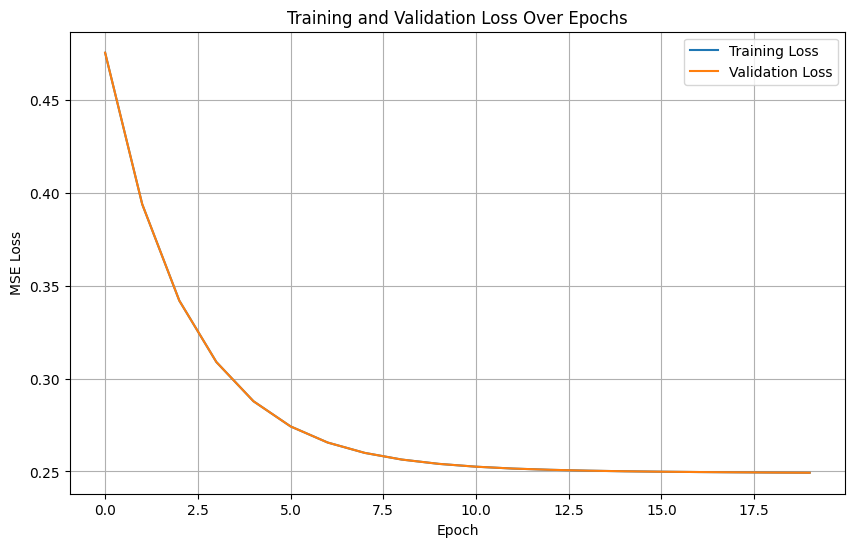

In [215]:
#Generated by Gemini

# Extract training loss data
train_epochs = [item[0] for item in m.train_loss]
train_losses = [item[1] for item in m.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in m.val_loss]
val_losses = [item[1] for item in m.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Create XOR model with SGD Momentum


In [216]:
optimizer_sgd_momentum = Optim_SGD_Momentum(mom_beta=0.9)
model_sgd_momentum = Model(
    blocks=[Dense(layNum=2, inL=2, midL=8, outL=1, activ="relu", f_activ="relu")],
    loss_fn=mse_loss,
    optimizer=optimizer_sgd_momentum
)

print("Training model with SGD Momentum...")
model_sgd_momentum.train(epochs=50, x_t=x, y_t=y, x_v=x, y_v=y, l_rate=0.1, val_run=10)

print("\nPredictions after training with SGD Momentum:")
predictions_sgd_momentum = model_sgd_momentum(x)
print(predictions_sgd_momentum)

Training model with SGD Momentum...
epoch: 0 	 loss: 0.43119533449838465
epoch: 10 	 loss: 0.24968937704421423
epoch: 20 	 loss: 0.27138620809020053
epoch: 30 	 loss: 0.24594340694380207
epoch: 40 	 loss: 0.22625995295900492
ep49: b0/1
Predictions after training with SGD Momentum:
vals: array([[0.39817713],
       [0.39817713],
       [0.87493072],
       [0.39817713]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])


## Create XOR model with AdaGrad


In [217]:
optimizer_adagrad = Optim_AdaGrad(gamma=0.0000001)
model_adagrad = Model(
    blocks=[Dense(layNum=2, inL=2, midL=8, outL=1, activ="relu", f_activ="relu")],
    loss_fn=mse_loss,
    optimizer=optimizer_adagrad
)

print("Training model with AdaGrad...")
model_adagrad.train(epochs=50, x_t=x, y_t=y, x_v=x, y_v=y, l_rate=0.1, val_run=10)

print("\nPredictions after training with AdaGrad:")
predictions_adagrad = model_adagrad(x)
print(predictions_adagrad)

Training model with AdaGrad...
epoch: 0 	 loss: 0.4221765276812092
epoch: 10 	 loss: 0.2519658306229129
epoch: 20 	 loss: 0.25056992883126006
epoch: 30 	 loss: 0.25014748909745754
epoch: 40 	 loss: 0.25003403146785974
ep49: b0/1
Predictions after training with AdaGrad:
vals: array([[0.4957433 ],
       [0.49916958],
       [0.49978496],
       [0.50321124]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])


## Create XOR model with RMSProp


In [218]:
optimizer_rmsprop = Optim_RMSPropclass(decay_rate=0.9, gamma=0.000001)
model_rmsprop = Model(
    blocks=[Dense(layNum=2, inL=2, midL=8, outL=1, activ="relu", f_activ="relu")],
    loss_fn=mse_loss,
    optimizer=optimizer_rmsprop
)

print("Training model with RMSProp...")
model_rmsprop.train(epochs=50, x_t=x, y_t=y, x_v=x, y_v=y, l_rate=0.1, val_run=10)

print("\nPredictions after training with RMSProp:")
predictions_rmsprop = model_rmsprop(x)
print(predictions_rmsprop)

Training model with RMSProp...
epoch: 0 	 loss: 0.5
epoch: 10 	 loss: 0.5
epoch: 20 	 loss: 0.5
epoch: 30 	 loss: 0.5
epoch: 40 	 loss: 0.5
ep49: b0/1
Predictions after training with RMSProp:
vals: array([[0.],
       [0.],
       [0.],
       [0.]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])


# Task
1. Instantiate the base `Optimizer` class, create a `Model` instance for the XOR problem, train it using regular SGD, and display the predictions.
2. Correct the `Optim_Adam` class definition to properly update parameters by replacing `x -= l_rate*s_hat/(self.gamma + r_hat**0.5) *p.grad` with `p.vals -= l_rate * s_hat / (self.gamma + r_hat**0.5)`. Then, instantiate the corrected `Optim_Adam` class, create a `Model` instance for the XOR problem, train it, and display the predictions.

## Create XOR model with regular SGD

In [219]:
optimizer_sgd = Optimizer()
model_sgd = Model(
    blocks=[Dense(layNum=2, inL=2, midL=8, outL=1, activ="relu", f_activ="relu")],
    loss_fn=mse_loss,
    optimizer=optimizer_sgd
)

print("Training model with regular SGD...")
model_sgd.train(epochs=50, x_t=x, y_t=y, x_v=x, y_v=y, l_rate=0.1, val_run=10)

print("\nPredictions after training with regular SGD:")
predictions_sgd = model_sgd(x)
print(predictions_sgd)

Training model with regular SGD...
epoch: 0 	 loss: 0.5
epoch: 10 	 loss: 0.5
epoch: 20 	 loss: 0.5
epoch: 30 	 loss: 0.5
epoch: 40 	 loss: 0.5
ep49: b0/1
Predictions after training with regular SGD:
vals: array([[0.],
       [0.],
       [0.],
       [0.]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])


## Create XOR model with Adam

In [220]:
optimizer_adam = Optim_Adam(beta1=0.9, beta2=0.999)
model_adam = Model(
    blocks=[Dense(layNum=2, inL=2, midL=8, outL=1, activ="relu", f_activ="relu")],
    loss_fn=mse_loss,
    optimizer=optimizer_adam
)

print("Training model with Adam...")
model_adam.train(epochs=50, x_t=x, y_t=y, x_v=x, y_v=y, l_rate=0.1, val_run=10)

print("\nPredictions after training with Adam:")
predictions_adam = model_adam(x)
print(predictions_adam)


Training model with Adam...
epoch: 0 	 loss: 0.4526323366559431
epoch: 10 	 loss: 0.2558279700546716
epoch: 20 	 loss: 0.2522967939646953
epoch: 30 	 loss: 0.23990670487985202
epoch: 40 	 loss: 0.18140927757561864
ep49: b0/1
Predictions after training with Adam:
vals: array([[0.        ],
       [0.70879254],
       [0.70879254],
       [0.70879254]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])


### Loss Plot for Regular SGD Model

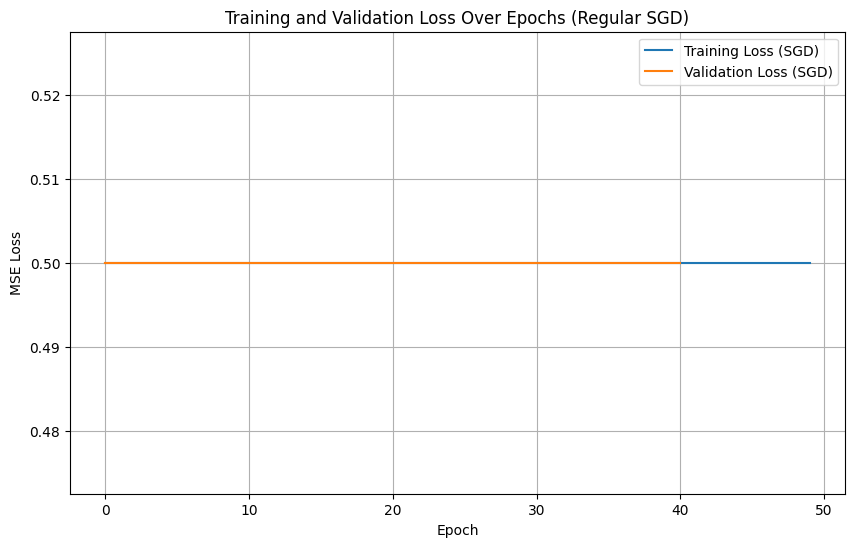

In [221]:
# Extract training loss data for SGD
train_epochs_sgd = [item[0] for item in model_sgd.train_loss]
train_losses_sgd = [item[1] for item in model_sgd.train_loss]

# Extract validation loss data for SGD
val_epochs_sgd = [item[0] for item in model_sgd.val_loss]
val_losses_sgd = [item[1] for item in model_sgd.val_loss]

# Create the plot for SGD
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_sgd, train_losses_sgd, label='Training Loss (SGD)')
plt.plot(val_epochs_sgd, val_losses_sgd, label='Validation Loss (SGD)')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs (Regular SGD)')
plt.legend()
plt.grid(True)
plt.show()

### Loss Plot for SGD Momentum Model

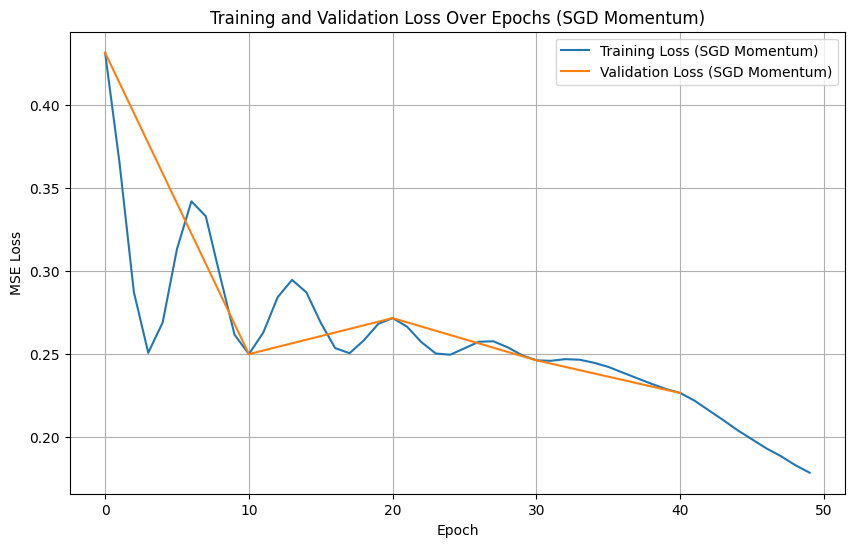

In [222]:
# Extract training loss data for SGD Momentum
train_epochs_momentum = [item[0] for item in model_sgd_momentum.train_loss]
train_losses_momentum = [item[1] for item in model_sgd_momentum.train_loss]

# Extract validation loss data for SGD Momentum
val_epochs_momentum = [item[0] for item in model_sgd_momentum.val_loss]
val_losses_momentum = [item[1] for item in model_sgd_momentum.val_loss]

# Create the plot for SGD Momentum
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_momentum, train_losses_momentum, label='Training Loss (SGD Momentum)')
plt.plot(val_epochs_momentum, val_losses_momentum, label='Validation Loss (SGD Momentum)')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs (SGD Momentum)')
plt.legend()
plt.grid(True)
plt.show()

### Loss Plot for AdaGrad Model

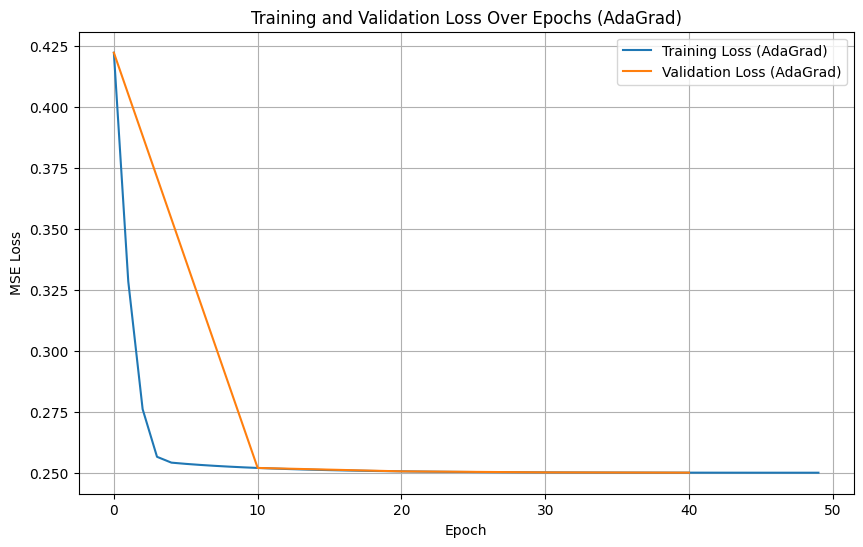

In [223]:
# Extract training loss data for AdaGrad
train_epochs_adagrad = [item[0] for item in model_adagrad.train_loss]
train_losses_adagrad = [item[1] for item in model_adagrad.train_loss]

# Extract validation loss data for AdaGrad
val_epochs_adagrad = [item[0] for item in model_adagrad.val_loss]
val_losses_adagrad = [item[1] for item in model_adagrad.val_loss]

# Create the plot for AdaGrad
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_adagrad, train_losses_adagrad, label='Training Loss (AdaGrad)')
plt.plot(val_epochs_adagrad, val_losses_adagrad, label='Validation Loss (AdaGrad)')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs (AdaGrad)')
plt.legend()
plt.grid(True)
plt.show()

### Loss Plot for RMSProp Model

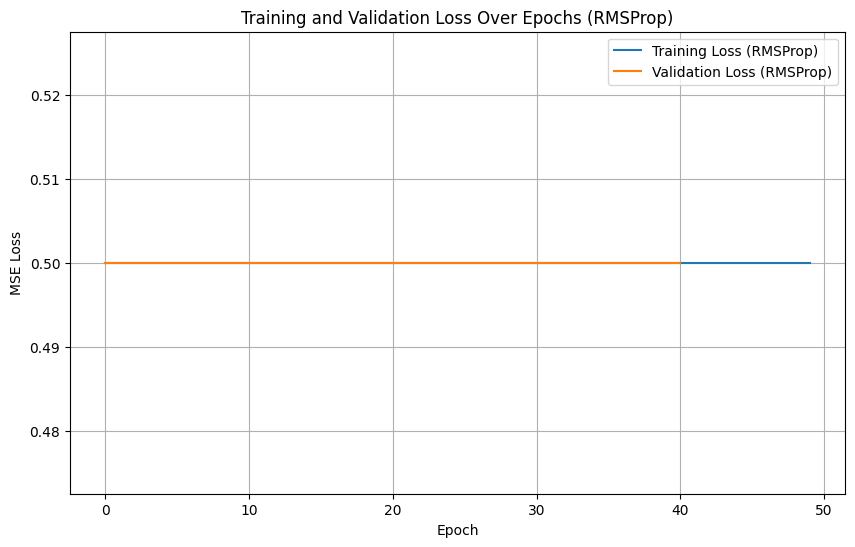

In [224]:
# Extract training loss data for RMSProp
train_epochs_rmsprop = [item[0] for item in model_rmsprop.train_loss]
train_losses_rmsprop = [item[1] for item in model_rmsprop.train_loss]

# Extract validation loss data for RMSProp
val_epochs_rmsprop = [item[0] for item in model_rmsprop.val_loss]
val_losses_rmsprop = [item[1] for item in model_rmsprop.val_loss]

# Create the plot for RMSProp
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_rmsprop, train_losses_rmsprop, label='Training Loss (RMSProp)')
plt.plot(val_epochs_rmsprop, val_losses_rmsprop, label='Validation Loss (RMSProp)')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs (RMSProp)')
plt.legend()
plt.grid(True)
plt.show()

### Loss Plot for Adam Model

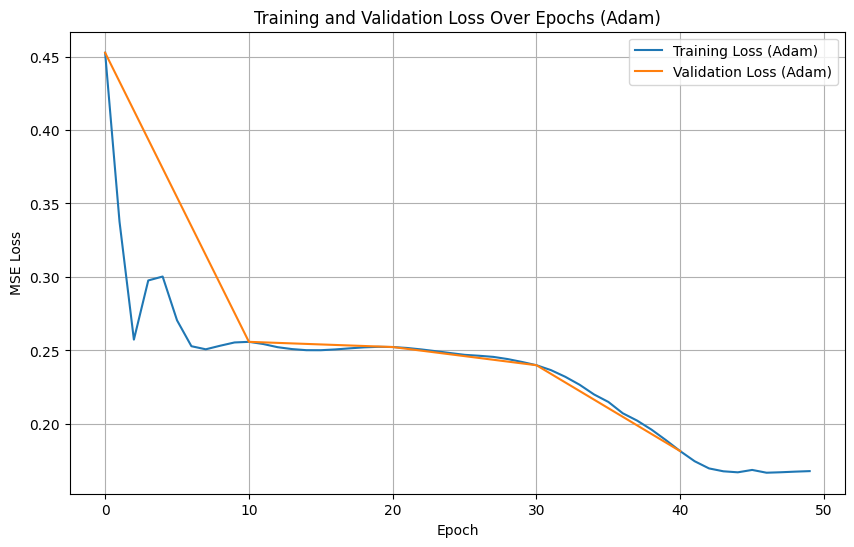

In [225]:
# Extract training loss data for Adam
train_epochs_adam = [item[0] for item in model_adam.train_loss]
train_losses_adam = [item[1] for item in model_adam.train_loss]

# Extract validation loss data for Adam
val_epochs_adam = [item[0] for item in model_adam.val_loss]
val_losses_adam = [item[1] for item in model_adam.val_loss]

# Create the plot for Adam
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_adam, train_losses_adam, label='Training Loss (Adam)')
plt.plot(val_epochs_adam, val_losses_adam, label='Validation Loss (Adam)')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs (Adam)')
plt.legend()
plt.grid(True)
plt.show()

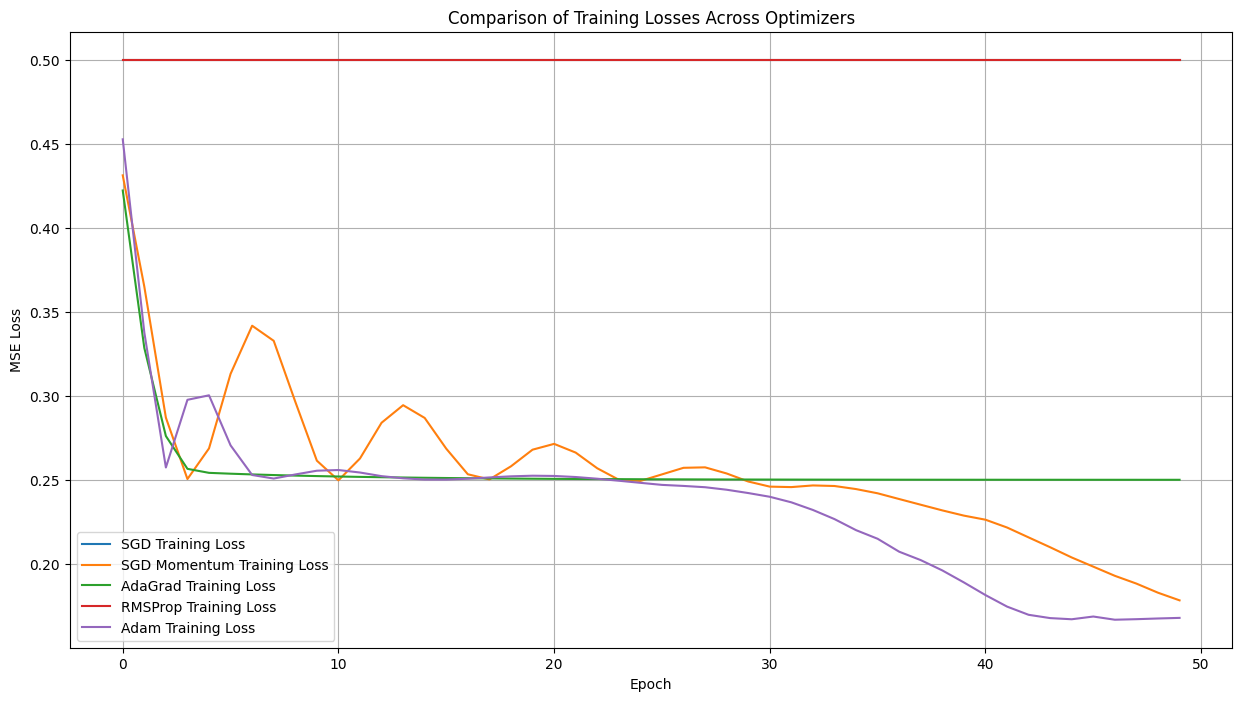

In [226]:
# Create a new figure for the comparison plot
plt.figure(figsize=(15, 8))

# Plot for Regular SGD
plt.plot([item[0] for item in model_sgd.train_loss], [item[1] for item in model_sgd.train_loss], label='SGD Training Loss', linestyle='-')

# Plot for SGD Momentum
plt.plot([item[0] for item in model_sgd_momentum.train_loss], [item[1] for item in model_sgd_momentum.train_loss], label='SGD Momentum Training Loss', linestyle='-')

# Plot for AdaGrad
plt.plot([item[0] for item in model_adagrad.train_loss], [item[1] for item in model_adagrad.train_loss], label='AdaGrad Training Loss', linestyle='-')

# Plot for RMSProp
plt.plot([item[0] for item in model_rmsprop.train_loss], [item[1] for item in model_rmsprop.train_loss], label='RMSProp Training Loss', linestyle='-')

# Plot for Adam
plt.plot([item[0] for item in model_adam.train_loss], [item[1] for item in model_adam.train_loss], label='Adam Training Loss', linestyle='-')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Comparison of Training Losses Across Optimizers')
plt.legend()
plt.grid(True)
plt.show()